In [1]:
using CRCBS
using Distributions
using HCubature
using Plots
using Combinatorics

┌ Info: Recompiling stale cache file /home/peltzer/.julia/compiled/v1.0/CRCBS/26Ksw.ji for CRCBS [edef75b8-3ac4-11e9-0392-bf149c536ee3]
└ @ Base loading.jl:1190
┌ Warning: Package CRCBS does not have JLD in its dependencies:
│ - If you have CRCBS checked out for development and have
│   added JLD as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CRCBS
└ Loading JLD into CRCBS from project dependency, future warnings for CRCBS are suppressed.
┌ Warning: Replacing docs for `CRCBS.get_dist_matrix :: Tuple{LightGraphs.AbstractGraph}` in module `CRCBS`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `CRCBS.pad_matrix :: Union{Tuple{T}, Tuple{Array{T,2},Tuple{Int64,Int64},T}} where T` in module `CRCBS`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `CRCBS.compute_distance_matrix :: Tuple{Any,Any}` in module `CRCBS`
└ @ Base.Docs docs/Docs.jl:223


In [2]:
function integrate_node_with_box_nb(n1,t1,n2,t2,nn,lambda,dtcount;bound_radius=10.0)
    function h(x)
        y = x[1]
        t = x[2]
        density = (1-cdf(Gamma(nn,lambda),abs(t2-t1-y))) * pdf(Gamma(n1,lambda), t) * pdf(Gamma(n2,lambda),t-y)
        return density
    end

    tmax = (-n1*n2 + n1 + n2 - 1)*lambda/(1-n1)
    ymax = tmax - (n1-1)*lambda

    yleft = min(ymax,t1-t2)
    yright = max(ymax,t1-t2)

    tleft = max(0,min(tmax,t1-t2+(n1-1)/lambda))
    tright                                                                                                                                                                        =max(0,max(tmax,t1-t2+(n1-1)/lambda))

    left = [yleft-bound_radius,max(tleft-bound_radius,0)]
    right = [yright + bound_radius, tright+bound_radius]

    res1 = @timed(hcubature(h,left,right,maxevals=10^8))
    C,err = res1[1]
    dtint = res1[2] #time spent performing integration

    return C, err, dtint + dtcount
end

integrate_node_with_box_nb (generic function with 1 method)

In [3]:
function rand_integer_part_sum(k,n;limit=0)
    """Random integer partition of k integers summing to n"""
    random_limit_breach = rand(1:limit+1)-1
    list = integer_partitions(n+random_limit_breach)
    
    list_k = Vector{}()
    for elt in list
        if length(elt) == k
            r = random_limit_breach
            while r > 0
                unlucky = rand(1:k)
                elt[unlucky] -= 1
                r -= 1
            end
            push!(list_k,elt)
        end
    end
    return rand(list_k)
end

rand_integer_part_sum (generic function with 1 method)

In [4]:
function rand_integer_part(k,n;limit=10)
    """Random integer partition of k integers summing to n in absolute value"""
    list = integer_partitions(n+k) 
    list_k = Vector{}()
    for elt in list
        elt = elt .- 1.0
        if length(elt) == k
            unlucky_idxs = rand(1:k,rand(1:Int64(round(k/2))))
            for idx in unlucky_idxs
                if abs(elt[idx]) < limit
                    elt[idx] *= -1
                end
            end
            push!(list_k,elt)
        end
    end
    return rand(list_k)
end

rand_integer_part (generic function with 1 method)

### Varying λ

In [5]:
n1 = 11
n2 = 12
t1 = 10.0
t2 = 8.0
nm = 5.0
dtcount = 0.0

lambdas = collect(range(0.05,stop=10.0,step=0.05));

In [6]:
probabilities = [integrate_node_with_box_nb(n1,t1,n2,t2,nm,lambda,dtcount)[1] for lambda in lambdas];

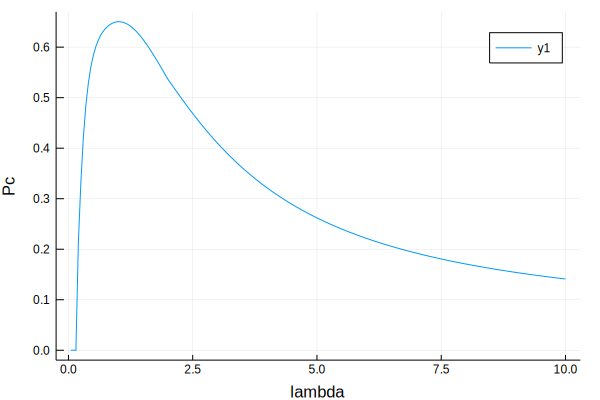

In [7]:
plot(lambdas,probabilities,xlabel="lambda",ylabel="Pc")

### Constant error on nm

In [8]:
n1 = 11
n2 = 12
t1 = 10.0
t2 = 8.0
lambda = 0.4
dtcount = 0.0

nm_error = collect(range(0,stop=10,step=1));

In [9]:
probabilities = [integrate_node_with_box_nb(n1*(1+nm),t1,n2*(1+nm),t2,5.0+nm,lambda,dtcount)[1] for nm in nm_error];

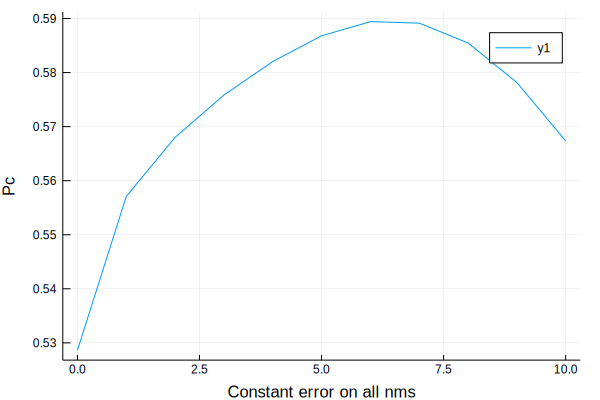

In [10]:
plot(nm_error,probabilities,xlabel="Constant error on all nms",ylabel="Pc")

### Varying nm only

In [11]:
n1 = 11
n2 = 15
t1 = 10.0
t2 = 8.0
nm = 11.0
lambda = 0.4
dtcount = 0.0

nm_error = collect(range(-10,stop=10,step=1));

In [12]:
probabilities = [integrate_node_with_box_nb(n1,t1,n2,t2,nm+nme,lambda,dtcount)[1] for nme in nm_error];

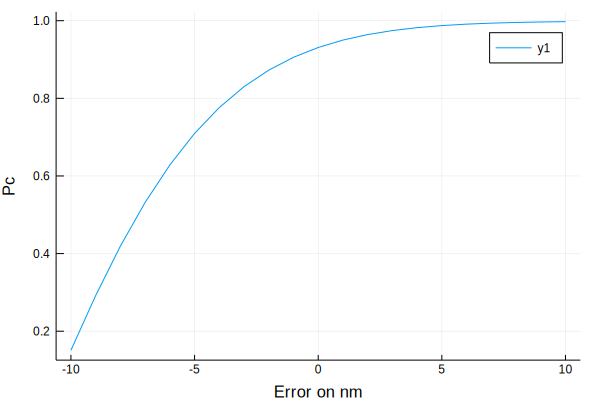

In [13]:
plot(nm_error,probabilities,xlabel="Error on nm",ylabel="Pc")

### Varying n1

In [14]:
n1 = 11
n2 = 15
t1 = 10.0
t2 = 8.0
lambda = 0.4
dtcount = 0.0

n1_error = collect(range(-10,stop=10,step=1));

In [15]:
probabilities = [integrate_node_with_box_nb(n1 + n1e,t1,n2,t2,nm,lambda,dtcount)[1] for n1e in n1_error];

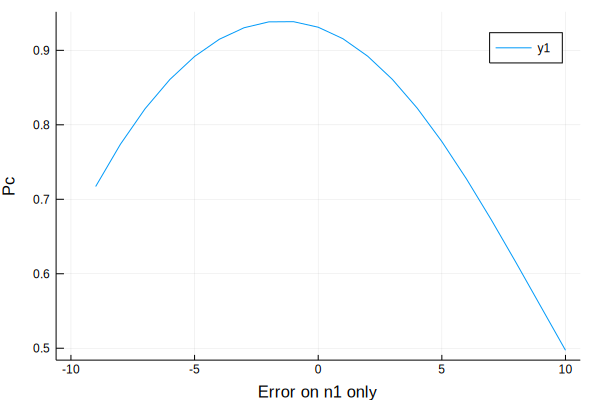

In [16]:
plot(n1_error,probabilities,xlabel="Error on n1 only",ylabel="Pc")

### Varying errors summing to k

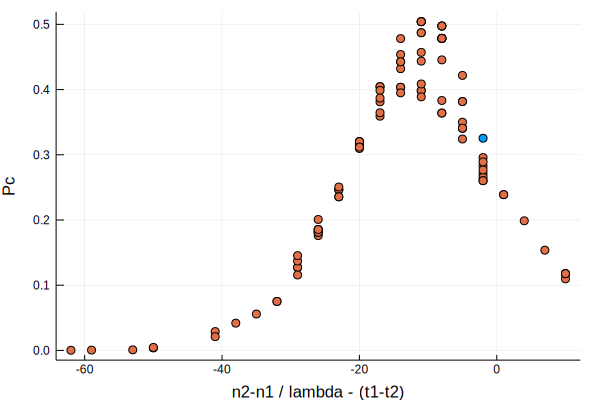

In [40]:
n1 = 11
n2 = 13
t1 = 10.0
t2 = 2.0
nm = 10.0
lambda = 3.0
dtcount = 0.0

errors = rand(1:20,100) #Errors sum to 1 -> errors sum to 20

plot(xlabel="n2-n1 / lambda - (t1-t2)",ylabel="Pc",leg=false)

for n in errors
    l = rand_integer_part(2,n;limit=4)
    probability = integrate_node_with_box_nb(n1+l[1],t1,n2+l[2],t2,nm,lambda,dtcount)[1]
    scatter!([(l[2]-l[1])*lambda + (n2-n1)*lambda - (t1-t2)],[probability],color=2)
    #scatter!([(l[2]-l[1])*lambda + (n2-n1)*lambda - 0.0],[probability],color=3)
end

# True value
scatter!([t2-t1 + (n2-n1)*lambda],[integrate_node_with_box_nb(n1,t1,n2,t2,nm,lambda,dtcount)[1]],color=1)

### Varying errors in a ball on all terms

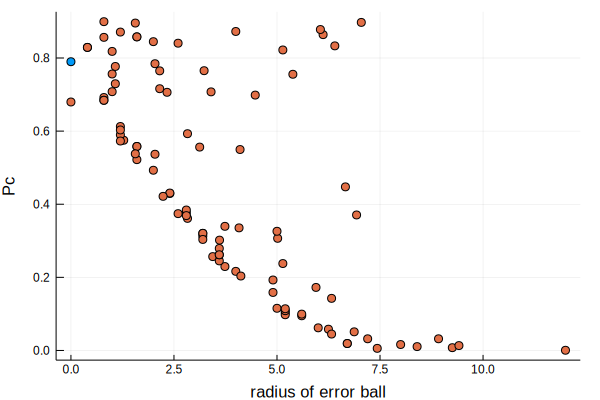

In [18]:
n1 = 11
n2 = 13
t1 = 10.0
t2 = 8.0
nm = 8.0
lambda = 0.4
dtcount = 0.0

errors = rand(1:30,100) #Errors sum to 1 -> errors sum to 20

plot(xlabel="radius of error ball",ylabel="Pc",leg=false)

for n in errors
    l = rand_integer_part(3,n;limit=6)
    probability = integrate_node_with_box_nb(n1+l[1],t1,n2+l[2],t2,nm+l[3],lambda,dtcount)[1]
    n2n1_sq = ((l[2]-l[1])*lambda)^2
    scatter!([sqrt(n2n1_sq + l[3]^2)],[probability],color=2)
end

# True value
scatter!([0],[integrate_node_with_box_nb(n1,t1,n2,t2,nm,lambda,dtcount)[1]],color=1)

### Set of n1-n2/lambda, nm which make probability greater than epsilon

In [19]:
lambdas = [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,4.0,5.0,6.0,7.0]
names = ["03","04","05","06","07","08","09","10","20","30","40","50","60","70"]

for (k,lambda) in enumerate(lambdas)
    a = plot_save(lambda)
    savefig(a,string("lambda",names[k],".pdf"))
end
    

UndefVarError: UndefVarError: plot_save not defined

In [20]:
function plot_save(lambda)    
    n1 = 11
    n2 = 13
    t1 = 10.0
    t2 = 2.0
    nm = 8.0
    dtcount = 0.0

    errors = rand(1:40,100) #Errors sum to 1 -> errors sum to 20
    errorlambda = rand(100)
    a = plot(xlabel="n2-n1/lambda",ylabel="nm",xlims=(-100,100),ylims=(0,20))
    marker = false

    for (k,n) in enumerate(errors)
        errl = 0 #errorlambda[k]
        l = rand_integer_part(3,n;limit=7)
        probability = integrate_node_with_box_nb(n1+l[1],t1,n2+l[2],t2,nm+l[3],abs(lambda+errl)+0.00,dtcount)[1]
        x = (n2+l[2]-n1-l[1])*lambda #(abs(lambda+errl)+0.01)
        y = nm + l[3]
        if probability > 0.1
            if marker == false
                scatter!([x],[y],color=1,label="P above threshold")
                marker = true
            else
                scatter!([x],[y],color=1,label="")
            end
        else
            scatter!([x],[y],color=2,label="")
        end
    end

    for (k,n) in enumerate(errors)
        errl = 0 #errorlambda[k]
        l = rand_integer_part(3,n;limit=7)
        probability = integrate_node_with_box_nb(n1+l[2],t1,n2+l[1],t2,nm+l[3],abs(lambda+errl)+0.0,dtcount)[1]
        x = (n2+l[1]-n1-l[2])*lambda
        y = nm + l[3]
        if probability > 0.1
            if marker == false
                scatter!([x],[y],color=1,label="P above threshold")
                marker = true
            else
                scatter!([x],[y],color=1,label="")
            end
        else
            scatter!([x],[y],color=2,label="")
        end
    end

    scatter!([(n2-n1)*lambda],[nm],color=3)

    return a
end

plot_save (generic function with 1 method)

In [21]:
savefig(a,"lambda40.pdf")

UndefVarError: UndefVarError: a not defined

In [23]:
myvector = Vector{Int64}()

0-element Array{Int64,1}

In [27]:
push!(myvector, 12)

4-element Array{Int64,1}:
  5
  3
  7
 12

In [29]:
myvector = myvector[2:end]

2-element Array{Int64,1}:
  7
 12

In [30]:
myvector[2] = 14

14

In [31]:
myvector

2-element Array{Int64,1}:
  7
 14